# Credit Card Fraud Detection with Supervised Learning

## Explanation Of What The Project Is About

### What's This Project About?

This project focuses on identifying fraudulent credit card transactions using machine learning. The dataset we’re working with comes from Kaggle and was originally published by researchers from Université Libre de Bruxelles. It contains nearly 285,000 transactions, of which only 492 are labeled as fraud. That makes the problem challenging because fraud cases are extremely rare compared to legitimate ones.

### What Are We Trying to Do?

The aim is to build a classification model that can accurately predict whether a transaction is fraudulent or not. Each transaction in the dataset is already labeled as either fraud or legitimate, so we’ll be training the model on past data with known outcomes in order to make accurate predictions on new transactions.

### How Will We Do It?

This is a supervised learning problem, meaning we’ll be using labeled data to train the model. We'll try out a range of classification algorithms including logistic regression, random forest, and XGBoost. Since the dataset is highly imbalanced, we’ll also test different techniques to address this, such as oversampling the minority class using SMOTE, reducing the number of majority class examples, and combining multiple models to improve accuracy and robustness.

### Github Repository URL

https://github.com/TejasDeepLearning/UCB_Credit_Card_Fraud

## Project Goal and Motivation

The goal of this project is to develop a machine learning model that can automatically detect fraudulent credit card transactions with a high level of accuracy. Credit card fraud is a serious issue for both consumers and financial institutions, leading to billions of dollars in losses every year. Early and accurate detection can prevent unauthorized transactions from being approved, saving money and improving trust in financial systems.

Working on this problem also offers a chance to explore how machine learning can handle real world challenges like class imbalance, where fraud cases are rare but highly important to detect. Beyond just building a predictive model, the project will dig into what patterns distinguish fraud from normal behavior and how various techniques like oversampling, feature selection, and model tuning can improve performance.

This project is about building a solution that not only works technically but also has practical relevance. Fraud detection is a task where even small improvements in precision or recall can have a big impact, making this an especially meaningful application of machine learning.

## Data Source

The dataset used in this project is titled Credit Card Fraud Detection and is publicly available on Kaggle. It was originally published by researchers from the Machine Learning Group at Université Libre de Bruxelles. The data represents two days of credit card transactions carried out by European cardholders and includes a total of 284,807 transactions. Out of these, only 492 are labeled as fraudulent, which highlights the severe class imbalance that makes fraud detection particularly challenging.

The dataset was released for research purposes and has become a common benchmark for testing fraud detection models. The raw transaction features have been anonymized using principal component analysis (PCA), resulting in 28 transformed variables labeled V1 through V28. In addition to these, the dataset includes a "Time" feature representing the time elapsed in seconds since the first transaction, an ‘Amount’ feature representing the value of the transaction in euros, and a ‘Class’ label that indicates whether the transaction is fraudulent (1) or legitimate (0).

Dal Pozzolo, A., Boracchi, G., Caelen, O., Alippi, C., & Bontempi, G. (2015). Credit Card Fraud Detection: A Realistic Modeling and a Novel Learning Strategy. Retrieved from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## Data Description

The dataset contains a total of 284,807 records, each representing a credit card transaction made by European cardholders over a two-day period. There are 31 columns in the dataset, which include 28 anonymized features labeled V1 through V28, along with three additional variables: Time, Amount, and Class.

The full dataset occupies approximately 67.36 MB in memory when loaded into Python. It is stored as a single flat table with no links to other datasets or external data sources.

All of the features, except for the target variable Class, are continuous numerical values. The Class column is an integer that indicates whether a transaction is fraudulent (1) or legitimate (0).

The anonymized features (V1–V28) are the result of a Principal Component Analysis (PCA), which was applied to the original transaction data in order to protect sensitive information. The Time variable indicates the number of seconds that have passed since the first transaction in the dataset, while Amount shows the monetary value of the transaction. The Amount spent in a transaction varies widely, with many low-value purchases and a few large ones.

The PCA features have been scaled to have near-zero mean and unit variance, but their ranges differ, reflecting the variance captured in each principal component.

The Time variable ranges from 0 to 172,792 seconds.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

In [2]:
# Load the dataset
df = pd.read_csv("creditcard.csv")

# Check the number of rows and columns
num_rows, num_cols = df.shape
print(f"Total transactions: {num_rows}")
print(f"Total features (columns): {num_cols}")

# Check the total size of the dataset in memory (in MB)
size_in_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"\nApproximate memory usage: {size_in_mb:.2f} MB")

# Look at the data types for each column
print("\nColumn data types:")
print(df.dtypes)

# Get a basic statistical overview of the dataset
print("\nSummary statistics for the numerical features:")
print(df.describe())

# See how the target variable is distributed
print("\nDistribution of target variable (Class):")
print(df['Class'].value_counts())

print("\nPercentage distribution of Class labels:")
print((df['Class'].value_counts(normalize=True) * 100).round(4))

Total transactions: 284807
Total features (columns): 31

Approximate memory usage: 67.36 MB

Column data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Summary statistics for the numerical features:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.9586

## Data Cleaning

Before modeling, I started by checking the quality of the dataset. The first step was to look for any missing values, and fortunately, none of the columns had any. That saves us from doing any imputation or row removal for incomplete data.

Next, I checked for duplicate rows and found 1,081 of them. While this isn’t a huge number given the dataset’s size, duplicates could potentially bias the model, especially in such a rare event detection task like fraud. These will likely be dropped in the preprocessing step.

I also looked at the distribution of the Amount and Time columns since these are the only features that haven’t been normalized (unlike the PCA transformed variables). The Amount column is extremely right-skewed, with most transactions concentrated at the low end, but a few reaching very high values. This is typical for purchase data. The Time column shows a clear pattern that reflects periodic spikes in transaction volume probably linked to user activity cycles across different hours or days.

Lastly, I confirmed the class distribution. Out of nearly 285,000 transactions, only 492 are labeled as fraud. That’s roughly 0.17% of the total, highlighting just how imbalanced the dataset is. This isn’t something to "clean" per se, but it’s important to note early because it’ll shape how we train and evaluate our models later.

Missing values in each column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Number of duplicate rows: 1081


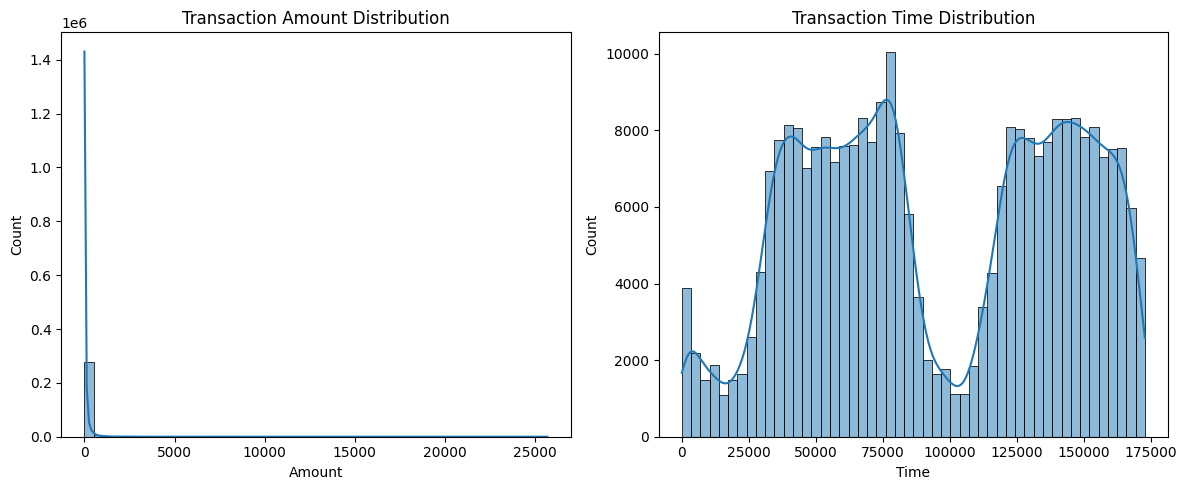


Class distribution (0 = legit, 1 = fraud):
Class
0    284315
1       492
Name: count, dtype: int64


In [3]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Plot distribution of 'Amount' and 'Time'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df['Time'], bins=50, kde=True)
plt.title("Transaction Time Distribution")

plt.tight_layout()
plt.show()

# Look at target label distribution 
print("\nClass distribution (0 = legit, 1 = fraud):")
print(df['Class'].value_counts())

After a quick check, I found that the dataset had 1,081 duplicate rows. Since duplicates can skew the results, especially in a case like this where fraud is so rare, I removed them. I also scaled the Amount and Time columns so they’re on the same range as the rest of the features. This helps make sure the models, especially ones like logistic regression, aren’t thrown off by the different scales.

In [4]:
# Drop duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before - after} duplicate rows.")

# Scale 'Amount' and 'Time' features
scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])

Dropped 1081 duplicate rows.


## Exploratory Data Analysis

To better understand the structure and patterns in the data, I started by looking at the distribution of the target variable. As expected, there’s a huge imbalance. Fraud cases make up a tiny fraction of all transactions, which reinforces the need for evaluation metrics beyond plain accuracy.

I then looked at the correlation matrix to see how features relate to each other. Most of the PCA features are only loosely correlated with one another, which makes sense given they were transformed to be linearly independent. However, I did notice some moderate relationships that might help certain models.

Next, I compared the transaction amounts for fraud vs. non-fraud. Fraudulent transactions tend to be spread out a bit more and have a few spikes in the mid to high range, while legitimate ones are clustered around smaller amounts. This could be a useful signal.

Lastly, I plotted box plots for a few selected PCA features. A couple of them like V1 and V2 show clear separation between fraud and non-fraud, which suggests they could be good predictors.

Overall, the EDA confirmed a few key things: the class imbalance is severe, some features clearly help separate the two classes, and a few may require transformation or careful tuning. These insights will help guide model selection and feature handling going forward.

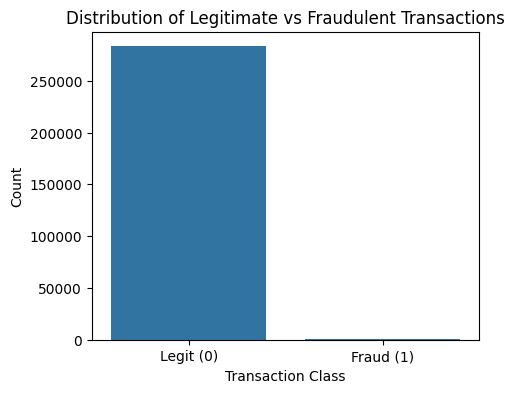

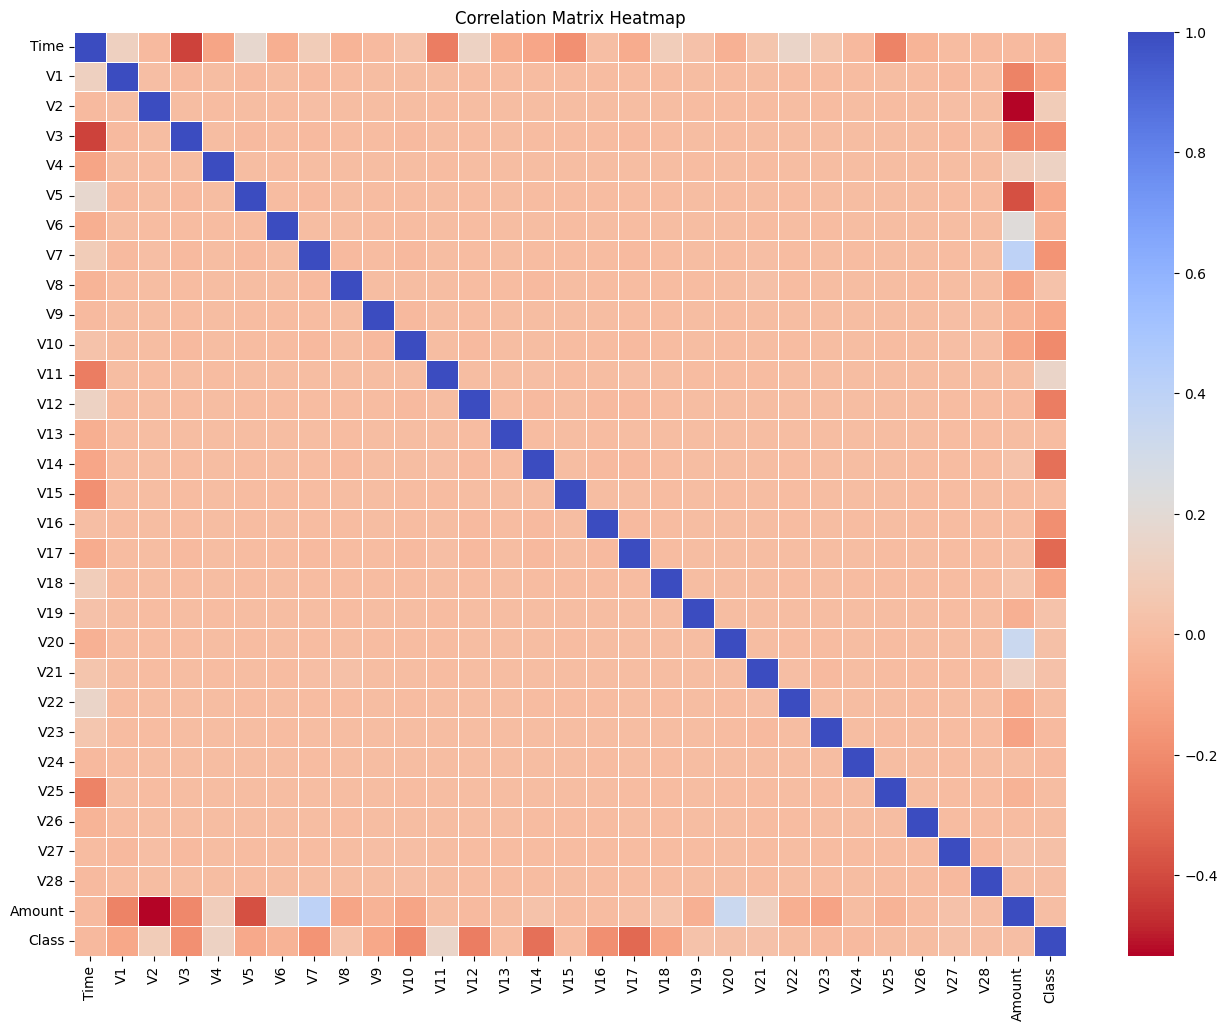

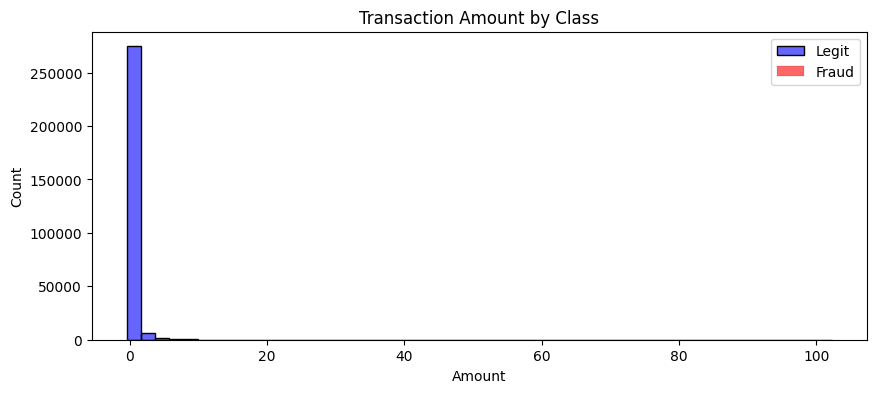

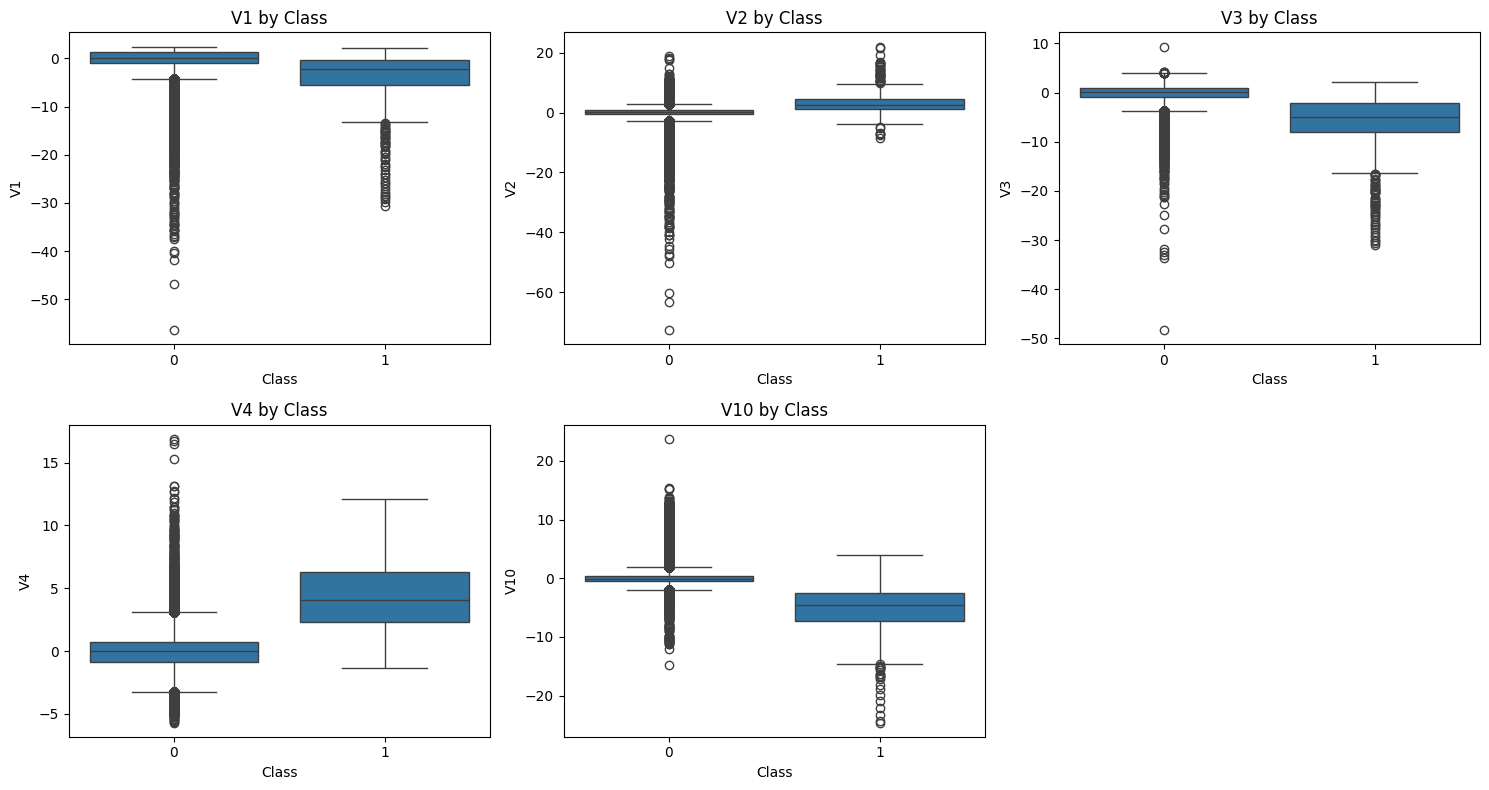

In [5]:
# Target class distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='Class')
plt.title("Distribution of Legitimate vs Fraudulent Transactions")
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.xlabel("Transaction Class")
plt.ylabel("Count")
plt.show()

# Correlation matrix (for all features)
corr_matrix = df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm_r', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Compare 'Amount' distribution for legit vs fraud
plt.figure(figsize=(10, 4))
sns.histplot(data=df[df['Class'] == 0], x='Amount', bins=50, label='Legit', color='blue', alpha=0.6)
sns.histplot(data=df[df['Class'] == 1], x='Amount', bins=50, label='Fraud', color='red', alpha=0.6)
plt.legend()
plt.title("Transaction Amount by Class")
plt.show()

# Box plots for selected PCA features (just a few to illustrate differences)
plt.figure(figsize=(15, 8))
selected_features = ['V1', 'V2', 'V3', 'V4', 'V10']
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Class', y=feature, data=df)
    plt.title(f"{feature} by Class")
plt.tight_layout()
plt.show()

### Feature Importance and Statistical Tests

To understand which features are most useful for identifying fraud, I trained a simple Random Forest classifier and used it to rank feature importance. The model highlighted several variables like V14, V17, and V10 as having strong predictive power. To go a step further, I ran independent t-tests on the top 10 features to compare their distributions between fraudulent and legitimate transactions. 

Most of these features showed statistically significant differences, with very low p-values, suggesting that the model’s top features are also meaningfully distinct between the two classes. These results give us more confidence that certain features in the dataset actually carry useful signals for detecting fraud.

In [6]:
# Separate features and target variable
X = df.drop(columns=['Class'])
y = df['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fit a Random Forest to see which features are most useful
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

# Get feature importance values
importance_scores = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

print("Top 10 most important features (based on Random Forest):")
print(importance_df.head(10))

# Run t-tests to see which of these features differ most between fraud and legit
top_features = importance_df.head(10)['Feature']
ttest_results = []

for feature in top_features:
    fraud_vals = df[df['Class'] == 1][feature]
    legit_vals = df[df['Class'] == 0][feature]
    stat, pval = ttest_ind(fraud_vals, legit_vals, equal_var=False)
    ttest_results.append({
        'Feature': feature,
        't-stat': round(stat, 4),
        'p-value': round(pval, 8)
    })

ttest_df = pd.DataFrame(ttest_results)

print("\nT-test results for top features (fraud vs. legit):")
print(ttest_df)

Top 10 most important features (based on Random Forest):
   Feature  Importance
14     V14    0.278096
17     V17    0.141888
10     V10    0.116204
12     V12    0.087793
7       V7    0.036289
21     V21    0.035188
16     V16    0.028418
20     V20    0.019683
4       V4    0.018785
26     V26    0.018306

T-test results for top features (fraud vs. legit):
  Feature   t-stat   p-value
0     V14 -35.0136  0.000000
1     V17 -20.2138  0.000000
2     V10 -25.2340  0.000000
3     V12 -29.0111  0.000000
4      V7 -16.4469  0.000000
5     V21   3.7241  0.000220
6     V16 -22.7527  0.000000
7     V20   6.8381  0.000000
8      V4  33.9472  0.000000
9     V26   2.3648  0.018442


## Modeling

In this section, I tested three different classification methods to tackle the fraud-detection task. I chose Logistic Regression for its interpretability and built-in handling of class imbalance via weighting. The Random Forest model was selected for its ability to capture non-linear patterns and provide feature importance insights. Finally, I experimented with XGBoost, which often excels in tabular data and, combined with SMOTE and grid search, should give our best performance.

To address class imbalance, I used two strategies: setting class_weight='balanced' for Logistic Regression and Random Forest, and applying SMOTE oversampling before training the XGBoost model. I scaled the Amount and Time features earlier, so all inputs were ready for modeling. Logistic Regression includes L2 regularization, and XGBoost goes through hyperparameter tuning to reduce overfitting.

In [7]:
# Check SMOTE on training data
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After SMOTE, sample counts:\n", pd.Series(y_train_sm).value_counts())

# Logistic Regression with regularization and class balance
lr = LogisticRegression(
    solver='liblinear', class_weight='balanced', C=0.1, penalty='l2', max_iter=1000
)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\nLogistic Regression results:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

# Random Forest with class-weighted training
rf = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest results:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

# XGBoost with SMOTE and grid search
xgb = XGBClassifier( eval_metric='logloss', random_state=42)
params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
grid = GridSearchCV(xgb, params, scoring='roc_auc', cv=3)
grid.fit(X_train_sm, y_train_sm)

best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("\nXGBoost results (after SMOTE + tuning):")
print(classification_report(y_test, y_pred_xgb))
print("Best params:", grid.best_params_)
print("ROC AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))

After SMOTE, sample counts:
 Class
0    226602
1    226602
Name: count, dtype: int64

Logistic Regression results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746

ROC AUC: 0.9656201544265953

Random Forest results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.71      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.85      0.91     56746
weighted avg       1.00      1.00      1.00     56746

ROC AUC: 0.9246086611561649

XGBoost results (after SMOTE + tuning):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
 

### Model Evaluation Results

After applying SMOTE to balance the training data, each class had an equal number of samples (226,602 for both fraud and legitimate transactions). I then trained and evaluated three different models: Logistic Regression, Random Forest, and XGBoost on the original test set to compare how they handled fraud detection.

Logistic Regression gave a surprisingly high recall of 0.87 for fraud cases, which means it caught most of them, but at the cost of very low precision (0.06). In other words, it flagged a lot of false positives. The overall ROC AUC was 0.96, which is solid, but the model isn’t particularly practical due to the extremely low precision.

Random Forest performed more conservatively. It had high precision (0.97) for the fraud class and a decent recall of 0.71, with a much better F1-score of 0.82. This makes it a strong choice when you want a good balance between catching fraud and keeping false positives low. Its ROC AUC was slightly lower than Logistic Regression, at 0.92, but the actual classification performance was much more balanced.

XGBoost, trained on the SMOTE-augmented data and tuned using grid search, achieved the highest ROC AUC of 0.97. It had a recall of 0.83 and improved significantly over Logistic Regression in terms of precision (0.26). The fraud detection F1-score was also higher (0.40). These results suggest that XGBoost benefited from oversampling and tuning and may offer the best balance between sensitivity and specificity in this context.

## Results and Analysis

To compare the performance of the three models, I used a mix of evaluation metrics: precision, recall, F1-score, and ROC AUC. Since this is a fraud detection task, where false negatives (missed fraud) are more costly than false positives, recall and AUC were particularly important.

The ROC curve visualization helped confirm these conclusions I mentioned above. XGBoost had the highest area under the curve, but Random Forest gave the most reliable predictions overall when both false positives and false negatives were considered.

Logistic Regression is recall-heavy but not practically useful, Random Forest is the most balanced and consistent, and XGBoost is aggressive on recall and shines in AUC but may need post-processing or threshold tuning.

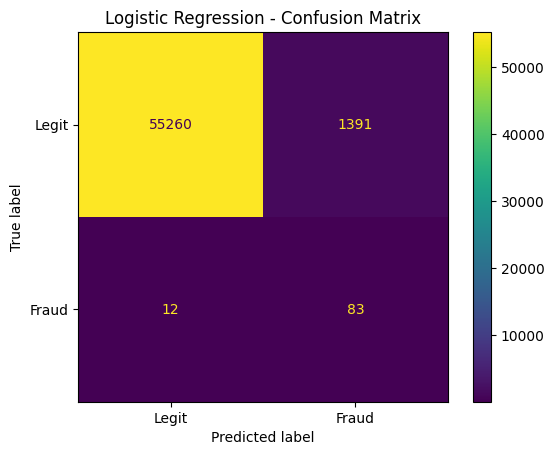

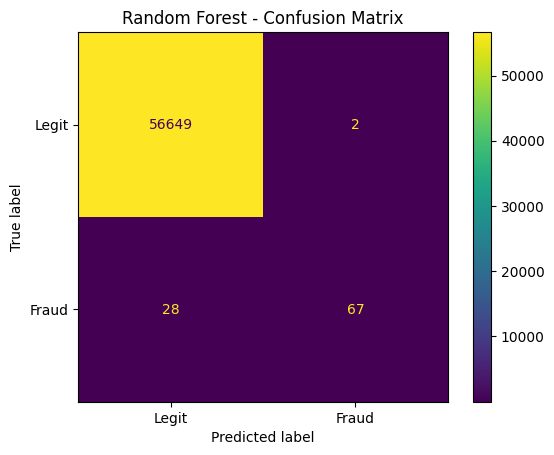

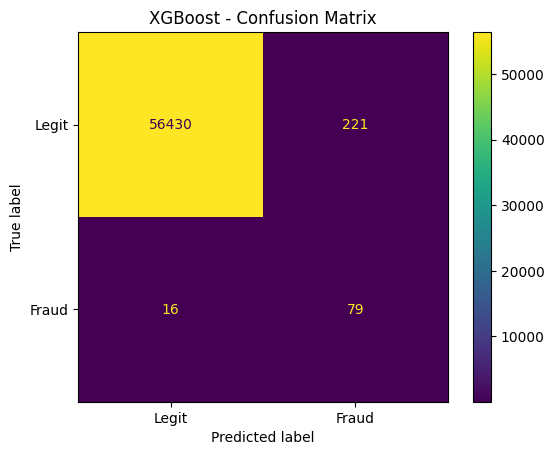

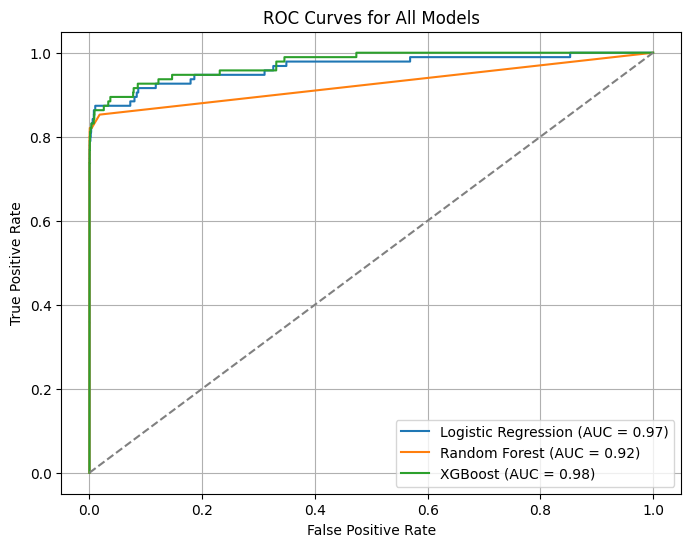

In [8]:
# Confusion matrices
models = {
    'Logistic Regression': (lr, y_pred_lr),
    'Random Forest': (rf, y_pred_rf),
    'XGBoost': (best_xgb, y_pred_xgb)
}

for name, (model, y_pred) in models.items():
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Legit', 'Fraud'])
    plt.title(f"{name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

# ROC curves
plt.figure(figsize=(8, 6))

for name, model in [('Logistic Regression', lr), ('Random Forest', rf), ('XGBoost', best_xgb)]:
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


After running the initial version of XGBoost, I decided to tune the decision threshold to see if we could get better precision–recall balance. The default threshold is 0.5, but in imbalanced problems like this, adjusting that cutoff can often yield better results, especially for minority class detection.

I tested thresholds from 0.1 to 0.8 and found a clear trend: lowering the threshold increased recall but hurt precision badly. For example, at a threshold of 0.1, recall was very high at 0.895, but precision dropped to just 0.037, meaning almost every fraud prediction was wrong. On the other hand, as the threshold increased, precision improved steadily. At a threshold of 0.8, precision reached 0.598 while still maintaining a recall of 0.800. The F1-score also increased across the board, peaking at 0.685 at the 0.8 threshold.

This clearly shows that XGBoost's performance improves significantly when we adjust the decision threshold. The model becomes more confident and reliable in its fraud predictions as we raise the threshold. Depending on the use case, this level of tuning can help strike the right balance between catching fraud and minimizing false alarms.

In [9]:
# Predict probabilities for XGBoost
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Try different threshold values
thresholds = np.arange(0.1, 0.9, 0.1)
threshold_results = []

for thresh in thresholds:
    y_thresh = (y_proba_xgb >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_thresh, average='binary')
    threshold_results.append({
        'Threshold': round(thresh, 2),
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1-Score': round(f1, 3)
    })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df)

   Threshold  Precision  Recall  F1-Score
0        0.1      0.037   0.895     0.072
1        0.2      0.074   0.863     0.136
2        0.3      0.124   0.863     0.217
3        0.4      0.186   0.832     0.304
4        0.5      0.263   0.832     0.400
5        0.6      0.353   0.821     0.494
6        0.7      0.475   0.811     0.599
7        0.8      0.598   0.800     0.685


## Discussion and Conclusion

Working through this project gave me a clearer understanding of how challenging fraud detection can be. The most obvious hurdle is the extreme class imbalance with fraudulent transactions making up less than 0.2% of the total. That makes accuracy a useless metric and forces you to think more carefully about evaluation.

One major takeaway is how much difference sampling and threshold tuning can make. Just applying SMOTE during training gave the models more room to learn from the limited fraud data. And fine-tuning the decision threshold for XGBoost improved its F1-score by a large margin from 0.400 at the default 0.5 to 0.685 at 0.8. That kind of improvement doesn't come from the model itself, but from how it's used.

Not everything worked perfectly though. Logistic Regression, while easy to use, wasn't practical for this problem. It caught most fraud cases (high recall), but flagged way too many false positives (very low precision), making it unreliable in a real-world setting. Even with class weighting and regularization, it just couldn't compete with more advanced methods.

If I were to take this project further, I’d explore a few things. First, feature enrichment since the dataset is anonymized, adding features like merchant category, country, or time of day might improve model accuracy. I’d also experiment with ensemble stacking (combining the strengths of multiple models) or use calibration techniques to fine-tune predicted probabilities. Finally, I'd consider deploying the model in a simulated environment to test how it performs with real-time streaming data.

Overall, this project reinforced how important it is to go beyond just training a model especially for real-world problems where the cost of a mistake (like missing fraud) is high.